# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.utils
import random
import pylab
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$Q_{grad}(w_{old}) = \frac{1}{N} \left( \sum_{i=1}^N 2 x_i(y_i - \langle\,x_i,w\rangle) \right) + R(w_{old})$  
$R(w_{old}) = \sum_{i=1}^D w_{old_i}^2$  
$w_{new} = w_{old} - \alpha Q_{grad}(w_{old}) + \frac{2\sum_{i=1}^D w_{old_i}}{C}$  

Интуитивно градиент - штраф весов за выданную ошибку.

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

***Ваше решение здесь***

$a_i = \langle\,x_i,w\rangle$,   
$Q_{grad}(w_{old}) = \frac{1}{N} \left( \sum_{i=1}^N x_i(\frac{1}{1 + e^{-a_i} }- y_i)\right) + \frac{2\sum_{i=1}^D w_{old_i}}{C}$,   
$w_{new} = w_{old} - \alpha Q_{grad}(w_{old}) + \frac{2\sum_{i=1}^D w_{old_i}}{C}$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

***Ваше решение здеь***
$$X^TXw = X^TY$$
В силу произвольности $X^T$ для всей модели:
$$Xw = Y$$
$$L(w) =  \frac{1}{N}\left[(Y - Xw)(Y - Xw)^T \right] = 0$$
$$w = (X^TX + \frac{2w_{old}}{C})X^TY$$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

В данной задаче поиска оптимального $a(x_i)$ предсказание $p(y_i = 1 | x_i)$ не зависит от $\langle\,x_i,w\rangle$ в целом и $x_{ij},$ $j = 1,..D$ в частности.

Примем $p(y_i = 1 | x_i) = p$, $p(y_i = 0 | x_i) = 1 - p$, $t = \langle\,x_i,w\rangle$. Тогда, взяв производную по каждой координате $w_i$, получим:

$$\frac{p}{1 + e^{-t}} e^{-t} ( - x_{ij}) + (1 - p) (1 + \frac{1}{1 + e^{t}} e^{t}) x_{ij} = 0$$

В силу отсутствия в общем случае равенства $x_{ij} = 0$:  
$-p + (1 - p) e^{t} = 0$,  
$t = \log\frac{p}{1 - p}$,   
$a(x_i) = \frac{1}{1 + e^{-t}} = p$

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=10):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if shuffle:
        X, y = sklearn.utils.shuffle(X, y)
    for i in range(0, X.shape[0] - batch_size, batch_size):
        X_batch = np.concatenate((X[i:i + batch_size],
                                  np.ones(batch_size).reshape(-1, 1)), axis=1)
        y_batch = y[i:i + batch_size]
        yield (X_batch, y_batch.reshape(-1, 1))

In [11]:
def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=100, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.batch_generator = batch_generator
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        loss = 0
        if self.model_type == 'lin_reg':
            linear_pred = np.dot(X_batch, self.weights)
            error = y_batch - linear_pred
            loss = (np.dot(error.T, error) / y_batch.shape[0]
                    + np.dot(self.weights.T, self.weights) / self.C)[0, 0]
        elif self.model_type == 'log_reg':
            predict = sigmoid(np.dot(X_batch, self.weights))
            efunc = -y_batch * np.log(predict)
            - (1 - y_batch) * np.log(1 - predict)
            loss = (np.sum(efunc, axis=0) / y_batch.shape[0])[0]
            loss += np.dot(self.weights.T, self.weights)[0, 0] / self.C
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу 
                (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            linear_pred = np.dot(X_batch, self.weights)
            error = 2 * (linear_pred - y_batch) * X_batch
            loss_grad = np.sum(error, axis=0)
        elif self.model_type == 'log_reg':
            loss_grad = (sigmoid(np.dot(X_batch, self.weights)) 
                         - y_batch) * X_batch / y_batch.shape[0]
            loss_grad = np.sum(loss_grad, axis=0)
        loss_grad /= y_batch.shape[0]
        loss_grad += np.sum(2 * self.weights) / self.C
        return loss_grad.reshape(-1, 1)

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        k = X.shape[1] + 1
        self.weights = np.array([random.uniform(-1 / k, 1 / k)
                                 for i in range(k)]).reshape(-1, 1)
        self.alpha0 = self.alpha
        iteration = 0
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                self.errors_log['iter'].append(iteration)
                self.errors_log['loss'].append(batch_loss)
            iteration += 1
            self.alpha = self.alpha0 / iteration
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)
        if self.model_type == 'lin_reg':
            y_hat = np.array(np.round(np.dot(X, self.weights)), dtype=int)
        elif self.model_type == 'log_reg':
            y_hat = np.array(np.round(sigmoid(np.dot(X, self.weights))),
                             dtype=int)
        return y_hat


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [12]:
def plot_decision_boundary(clf, name):
    x = np.linspace(-5, 8, num=2)
    y = -((clf.weights[0]* x + clf.weights[2]) / clf.weights[1])
    plt.plot(x, y, label='{}'.format(name))

[[-1.14332081e+276]
 [ 2.07234549e+276]
 [ 7.17521011e+276]]
[[ 1.15798411]
 [-1.20654464]
 [-5.20489271]]


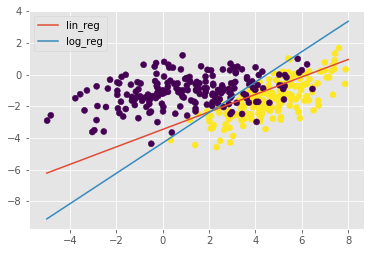

In [13]:
import random
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_clf1 = MySGDClassifier(batch_generator=batch_generator, C=10, alpha=0.8)
my_clf1.fit(X, y)
print(my_clf1.weights)
plot_decision_boundary(my_clf1, 'lin_reg')

my_clf2 = MySGDClassifier(batch_generator=batch_generator, 
                          model_type='log_reg', alpha=10, C=10000)
my_clf2.fit(X, y)
print(my_clf2.weights)
plot_decision_boundary(my_clf2, 'log_reg')

plt.scatter(X[:,0], X[:,1], c=y)
plt.legend()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [14]:
from sklearn.datasets import make_classification

In [15]:
X, y = make_classification(n_samples=10000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

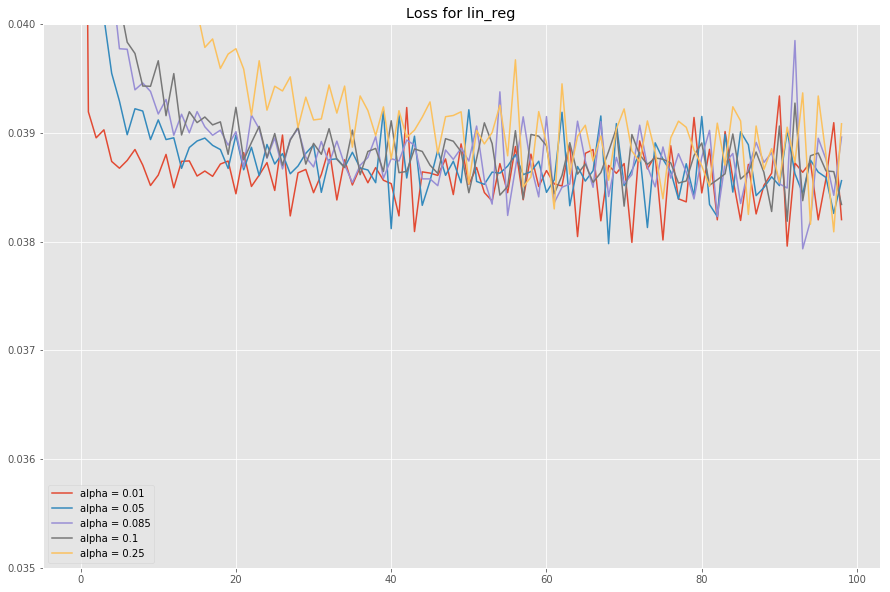

In [16]:
N = 1000
fig = plt.figure(figsize=(15,10))
for alpha in [0.01, 0.05, 0.085, 0.1, 0.25]:
    my_clf = MySGDClassifier(batch_generator=batch_generator, C=10000,
                             model_type='lin_reg', batch_size=10, alpha=alpha)
    my_clf.fit(X, y)
    length = len(my_clf.errors_log['loss'])
    y_axis = [np.sum(my_clf.errors_log['loss'][N*i:N*(i+1)])/N 
              for i in range(length//N)]
    x_axis = np.arange(length//N)
    pylab.ylim(0.035, 0.04)
    plt.plot(x_axis, y_axis, label='alpha = {}'.format(alpha))
plt.legend()    
plt.title('Loss for lin_reg')
plt.show()

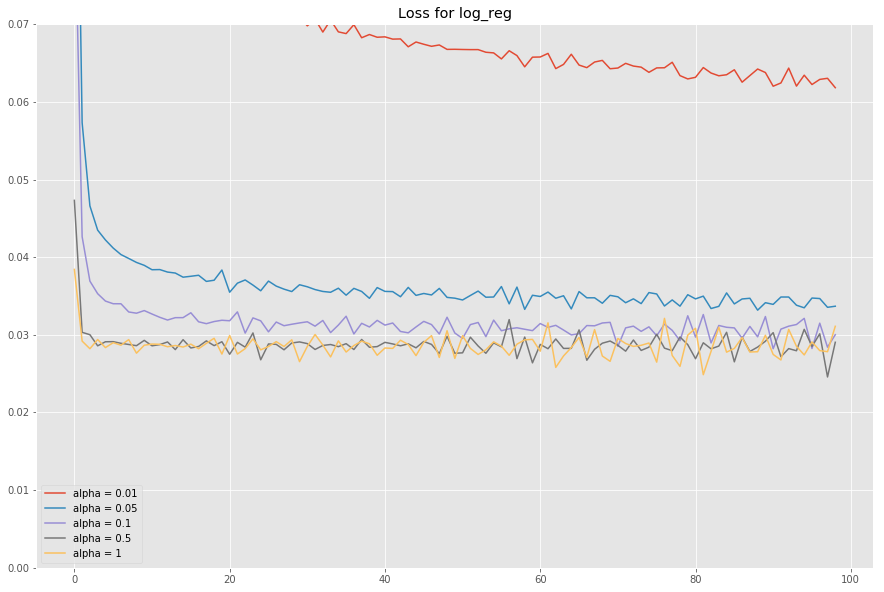

In [19]:
N = 1000
fig = plt.figure(figsize=(15,10))
for alpha in [0.01, 0.05, 0.1, 0.5, 1]:
    my_clf = MySGDClassifier(batch_generator=batch_generator, C=10000, 
                             model_type='log_reg', batch_size=10, alpha=alpha)
    my_clf.fit(X, y)
    length = len(my_clf.errors_log['loss'])
    y_axis = [np.sum(my_clf.errors_log['loss'][N*i:N*(i+1)])/N 
              for i in range(length//N)]
    x_axis = np.arange(length//N)
    pylab.ylim(0, 0.07)
    plt.plot(x_axis, y_axis, label='alpha = {}'.format(alpha))
plt.legend()    
plt.title('Loss for log_reg')
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

C:\Users\miracle\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\miracle\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in subtract
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in double_scalars


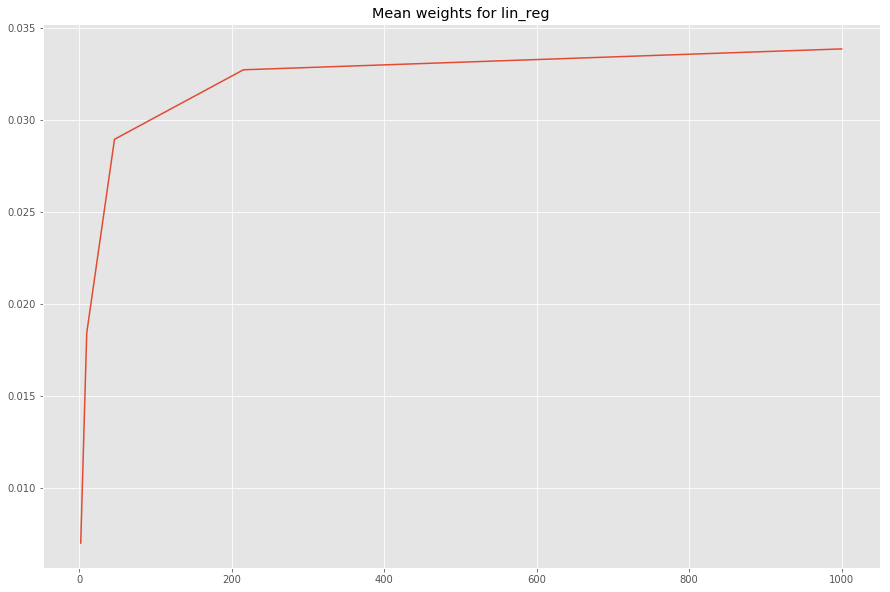

In [20]:
fig = plt.figure(figsize=(15,10))
x_axis = []
y_axis = []
for C in np.logspace(3, -3, 10):
    my_clf = MySGDClassifier(batch_generator=batch_generator, C=C, 
                             model_type='lin_reg', batch_size=10, alpha=0.085)
    my_clf.fit(X, y)
    x_axis.append(C)
    y_axis.append(my_clf.weights.mean())
plt.plot(x_axis, y_axis)
plt.title('Mean weights for lin_reg')
plt.show()

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in multiply
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in double_scalars
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars


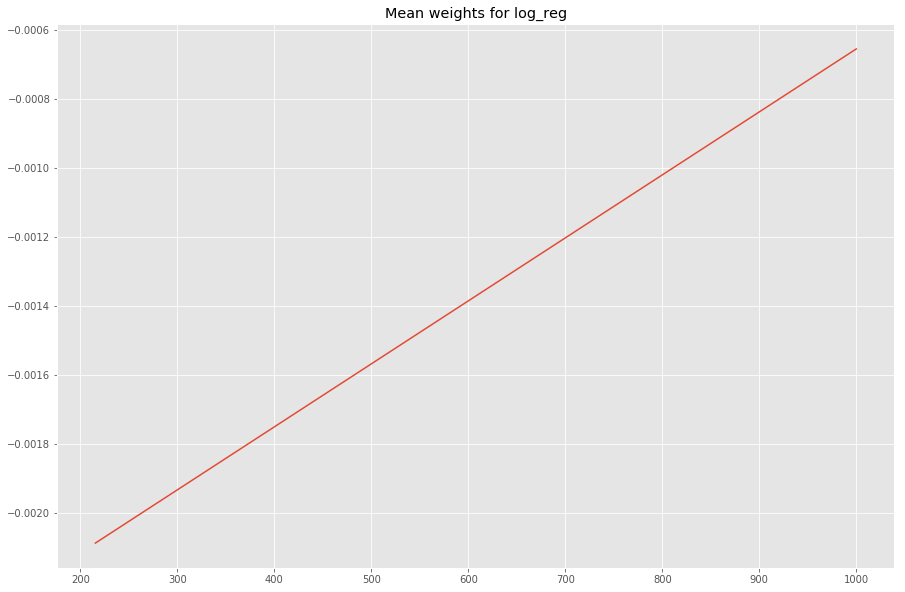

In [21]:
fig = plt.figure(figsize=(15,10))
x_axis = []
y_axis = []
for C in np.logspace(3, -3, 10):
    my_clf = MySGDClassifier(batch_generator=batch_generator, C=C, 
                             model_type='log_reg', batch_size=10, alpha=10)
    my_clf.fit(X, y)
    x_axis.append(C)
    y_axis.append(my_clf.weights.mean())
plt.plot(x_axis, y_axis)
plt.title('Mean weights for log_reg')
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [22]:
doc_to_title = {}
with open('docs_titles.tsv', 'r', encoding='utf-8-sig') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [23]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [24]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [25]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X = X_train
y = y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, 
                                                    stratify=y)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
my_clf = MySGDClassifier(model_type='lin_reg', batch_generator=batch_generator,
                         max_epoch=4, alpha=0.048, C=100, batch_size = 10)
my_clf.fit(X_train, y_train)
print(f1_score(y_test, my_clf.predict(X_test)))

0.46153846153846156


In [67]:
my_clf = MySGDClassifier(batch_generator=batch_generator, 
                         model_type='log_reg', max_epoch=5, alpha=0.0002,
                         C=1000, batch_size = 10)
%time my_clf.fit(X_train, y_train)
print(f1_score(y_test, my_clf.predict(X_test)))

Wall time: 737 ms
0.6486486486486487


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [68]:
train_data = pd.read_csv('test_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [69]:
X_test = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target) in enumerate(docs):
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_train = np.array(groups_train)

In [71]:
import csv
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
predict = my_clf.predict(X_test)
with open('submission.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for proba in predict:
        writer.writerow({'pair_id': str(i), 'target': str(proba[0])})
        i += 1
f.close()

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***

Линейная регрессия - интуитивно ясный алгоритм подбора параметров, которые с помощью простых арифметических операций способны описать зависимость одних величин от других, в то время как логистическая регрессия является более "продвинутым" алгоритмом за счет фундамента в виде теории вероятностей. И именно из-за этого логистическая регрессия лучше подходит для классифицирования объектов, ибо она выдает естественный для теории вероятностей бинарный ответ.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***

Для задач поиска зависимости одной величины от другой, когда данные в любом объеме имеют небольшое количество признаков и когда данные имеют большой разброс по значениям (так-то есть нормализация данных, но не суть). 

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***

1. $O(D + N)$
2. $O(D + \frac{N}{batch-size})$
3. $O(D)$

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

Я думаю, что лучше считать ошибку до спуска, ибо по ней мы можем оценить ситуацию, текущие веса и каким-то образом повлиятьь на спуск (и на все обучение в целом). Но полученная ошибка будет нести адекватную смысловую нагрузку только после хотя бы одного шага спуска, т.к. после инициализации весов трудно искусственно влиять на обучение.

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

Думаю, для определенных простых задач выявления линейных зависимостей (не берем в расчет ядра) такие модели подходят прекрасно, ведь их реализация не отнимет много времени при должных знаниях из-за своей простоты. Но в некотором смысле линейные модели - пережиток, т.к. нейронные сети обобщают их до многослойных линейных моделей, что явно дает более точные результаты и лучшую обобщаемость.

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Регуляризация и подбор параметров для сходимости (и максимального score'a).

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Интересно постигать (или не постигать порой) новое, печалит, что трудно (или невозможно) успеть переварить весь материал, но я бы сказал, что это дело "наживное" и нельзя научиться кататься на велосипеде, просто просматривая инструкцию.